In [1]:
import geopandas as gpd
import os

if os.path.exists("covid.geojson"):
    print("use file")
    df = gpd.read_file("covid.geojson")
else:
    print("download")
    df = gpd.read_file("https://dhsgis.wi.gov/server/rest/services/DHS_COVID19/COVID19_WI_V2/MapServer/9/query?outFields=*&where=1%3D1&f=geojson")
    df.to_file("covid.geojson")

use file


<AxesSubplot:>

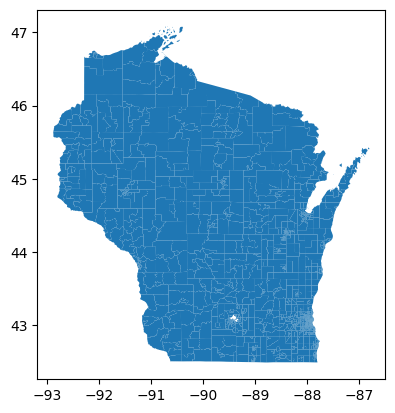

In [2]:
df.plot()

In [3]:
# How can we get a clean dataset of COVID deaths in WI?

In [4]:
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'TESTS_POS_CONF',
       'TESTS_POS_CONF_NEW', 'TESTS_POS_CONF_7DAYAVG', 'PercentNAATPos',
       'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG', 'POS_CUM_CONF',
       'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB', 'POS_NEW_PROB',
       'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF', 'DTH_7DAYAVG_CONF',
       'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB', 'DTH_7DAYAVG_PROB',
       'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP', 'POS_OTH_CP',
       'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP', 'DTHS_MALE_CP',
       'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP', 'DTHS_20_29_CP',
       'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP', 'DTHS_60_69_CP',
       'DTH

In [5]:
# TODO: in results, share what % of cells were guessed (imputed)
df = df.replace(-999, 2)

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

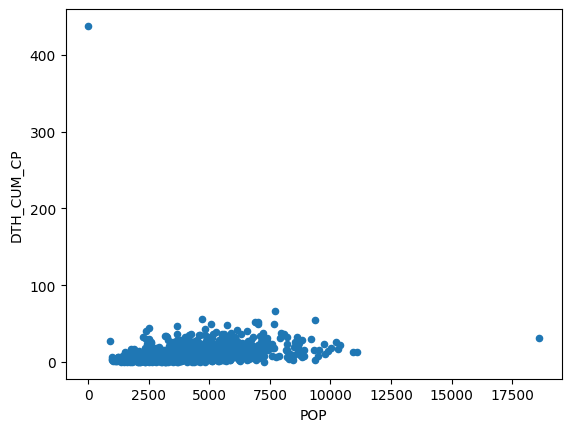

In [6]:
df.plot.scatter(x="POP", y="DTH_CUM_CP")

In [7]:
df[df["DTH_CUM_CP"] > 200]

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,Shape.STArea(),Shape.STLength(),geometry
1392,1668024000000,TRACT N/A,None,48333,40,33.71,438,0,0.0,0,...,21173,25324,1667887200000,0,NaN,2235,Census tract,466.180086,80.071546,"POLYGON ((-87.04159 44.13490, -87.04161 44.134..."


In [8]:
df["GEOID"].str.fullmatch(r"\d+").value_counts()

True     1392
False       1
Name: GEOID, dtype: int64

In [9]:
df = df[df["GEOID"].str.fullmatch(r"\d+")]

In [10]:
# How can we train/fit models to known data to predict unknowns?
# Population => Deaths, Cases => Deaths, Cases by Age => Deaths

# model = ????
# model.fit(X, y)
# y = model.predict(X)

In [11]:
df[["POP"]].head()

,POP
0,2870
1,1244
2,2599
3,4533
4,1603


In [12]:
df["DTH_CUM_CP"].head()

0    13
1     5
2     7
3    25
4     0
Name: DTH_CUM_CP, dtype: int64

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df[["POP"]], df["DTH_CUM_CP"])
y = model.predict(df[["POP"]])  # TODO: use different X values

In [14]:
import pandas as pd
predict_df = pd.DataFrame({"POP": [1000,2000,3000]})
predict_df["predicted deaths"] = model.predict(predict_df)
predict_df

,POP,predicted deaths
0,1000,3.794165
1,2000,6.026414
2,3000,8.258662


In [15]:
# How can we visualize model predictions?

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

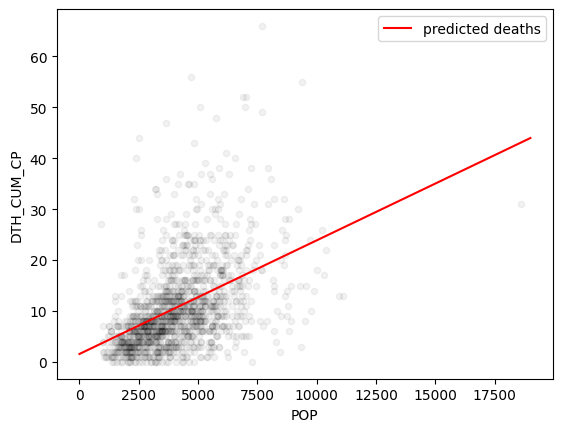

In [16]:
predict_df = pd.DataFrame({"POP": range(0, 20000, 1000)})
predict_df["predicted deaths"] = model.predict(predict_df)

ax = predict_df.plot.line(x="POP", y="predicted deaths", color="r")
df.plot.scatter(x="POP", y="DTH_CUM_CP", ax=ax, alpha=0.05, color="k")

In [17]:
# How can we get a formula for the relationship?
model.coef_

array([0.00223225])

In [18]:
model.coef_[0] # the slope of the line

0.002232248762253651

In [19]:
model.intercept_

1.561916052935402

In [20]:
f"deaths ~= population * {round(model.coef_[0], 4)} + {round(model.intercept_, 2)}"

'deaths ~= population * 0.0022 + 1.56'

In [21]:
# How well does our model fit the data?
# R^2 ("r squared") or explained variance

In [22]:
before = df["DTH_CUM_CP"].var() # variance/noise
before

73.5585656354066

In [23]:
# df[LIST]   => gets be a subset of the original columns in a new DataFrame

In [24]:
after1 = (df["DTH_CUM_CP"] - model.predict(df[["POP"]])).var()
after1

58.36158186387133

In [25]:
after2 = ((df["DTH_CUM_CP"] - model.predict(df[["POP"]])) ** 2).mean()
after2

58.31965544011855

In [26]:
improvement = before - after1
improvement / before # explained_var_score in sklearn

0.20659706507681502

In [27]:
improvement = before - after2
improvement / before # r2_score in sklearn

0.2071670384496046

In [28]:
model.score(df[["POP"]], df["DTH_CUM_CP"])   # does predict, then compares against the true values, then gives r2_score

0.20659706507681497

In [29]:
# Did our model learn, or just memorize (that is, "overfit")?
len(df) // 2

696

In [30]:
train, test = df.iloc[:len(df) // 2], df.iloc[len(df) // 2:] # manual train/test split

In [31]:
len(train), len(test)

(696, 696)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
train, test = train_test_split(df, test_size=0.25) # randomly shuffles each time
len(train), len(test)

(1044, 348)

In [34]:
xcols = ["POP"]
ycol = "DTH_CUM_CP"

model = LinearRegression()
model.fit(train[xcols], train[ycol])
#y = model.predict(test[xcols])
model.score(test[xcols], test[ycol])

0.21231325214456265

In [35]:
# How can we minimize noise due to random train/test splits?
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, train[xcols], train[ycol]) # it's further diving train into train/test data
scores

array([0.23882836, 0.24445836, 0.19441988, 0.12045462, 0.18483321])

In [36]:
scores.mean()

0.19659888608973985

In [37]:
# How can we compare models?
# model 1: POP => DEATHS
# model 2: CASES => DEATHS

model1 = LinearRegression()
model1_scores = cross_val_score(model1, df[["POP"]], df[["DTH_CUM_CP"]])

model2 = LinearRegression()
model2_scores = cross_val_score(model2, df[["POS_CUM_CP"]], df[["DTH_CUM_CP"]])

<AxesSubplot:>

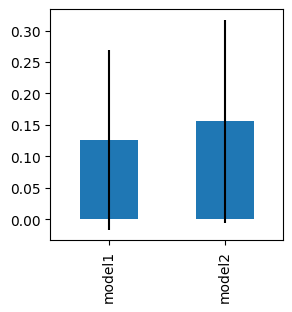

In [38]:
mean = pd.Series({"model1": model1_scores.mean(), "model2": model2_scores.mean()})
err = pd.Series({"model1": model1_scores.std(), "model2": model2_scores.std()})
mean.plot.bar(figsize=(3,3), yerr=err)

In [39]:
model1_scores.std()

0.142687797230536

In [42]:
# How can we use multiple x variables (multiple regression)?
# CASE BY AGE => DEATHS
xcols = ['POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP']
ycol = "DTH_CUM_CP"

model = LinearRegression()
model.fit(train[xcols], train[ycol])
model.score(test[xcols], test[ycol])  # calls predict on X values, r2_score on the predictions

0.6536848440978045

In [45]:
# How can we interpret what features the model is relying on?
model.coef_

array([-0.03314292,  0.00313729, -0.00164842,  0.01411027,  0.01270053,
       -0.0057806 ,  0.01214001, -0.00098436,  0.13468828,  0.19792902])

<AxesSubplot:>

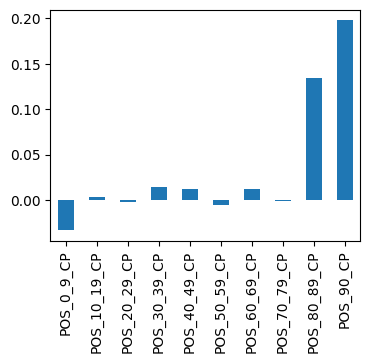

In [49]:
pd.Series(model.coef_, index=xcols).plot.bar(figsize=(4,3))